100%|██████████| 111/111 [05:24<00:00,  2.92s/it]


Epoch 1/10
Train Loss: 0.4885, Train Accuracy: 0.7760
Val Loss: 0.3757, Val Accuracy: 0.8339


100%|██████████| 111/111 [05:31<00:00,  2.98s/it]


Epoch 2/10
Train Loss: 0.3429, Train Accuracy: 0.8562
Val Loss: 0.2983, Val Accuracy: 0.8804


100%|██████████| 111/111 [03:32<00:00,  1.91s/it]


Epoch 3/10
Train Loss: 0.2740, Train Accuracy: 0.8878
Val Loss: 0.2199, Val Accuracy: 0.9070


100%|██████████| 111/111 [03:46<00:00,  2.04s/it]


Epoch 4/10
Train Loss: 0.2481, Train Accuracy: 0.9029
Val Loss: 0.2564, Val Accuracy: 0.8914


100%|██████████| 111/111 [03:39<00:00,  1.97s/it]


Epoch 5/10
Train Loss: 0.2329, Train Accuracy: 0.9049
Val Loss: 0.1979, Val Accuracy: 0.9204


100%|██████████| 111/111 [04:07<00:00,  2.23s/it]


Epoch 6/10
Train Loss: 0.2136, Train Accuracy: 0.9151
Val Loss: 0.1880, Val Accuracy: 0.9238


100%|██████████| 111/111 [03:46<00:00,  2.04s/it]


Epoch 7/10
Train Loss: 0.2127, Train Accuracy: 0.9163
Val Loss: 0.1794, Val Accuracy: 0.9291


100%|██████████| 111/111 [04:08<00:00,  2.24s/it]


Epoch 8/10
Train Loss: 0.2040, Train Accuracy: 0.9201
Val Loss: 0.2538, Val Accuracy: 0.8914


100%|██████████| 111/111 [04:16<00:00,  2.31s/it]


Epoch 9/10
Train Loss: 0.1961, Train Accuracy: 0.9231
Val Loss: 0.2061, Val Accuracy: 0.9167


100%|██████████| 111/111 [04:32<00:00,  2.45s/it]


Epoch 10/10
Train Loss: 0.2318, Train Accuracy: 0.9087
Val Loss: 0.2399, Val Accuracy: 0.9053
Classification Report:
                precision    recall  f1-score   support

    dysarthric       0.95      0.77      0.85      1236
non_dysarthric       0.89      0.98      0.93      2292

      accuracy                           0.91      3528
     macro avg       0.92      0.87      0.89      3528
  weighted avg       0.91      0.91      0.90      3528



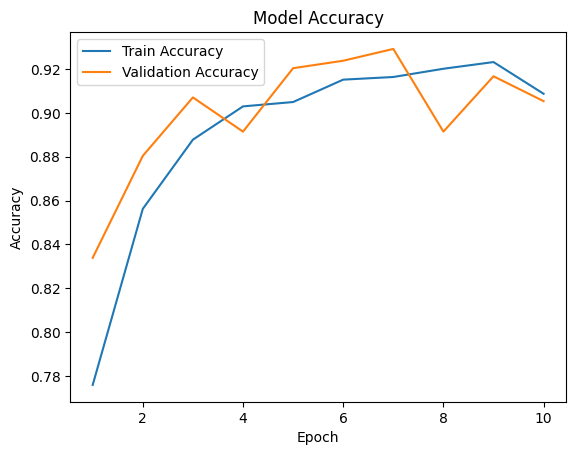

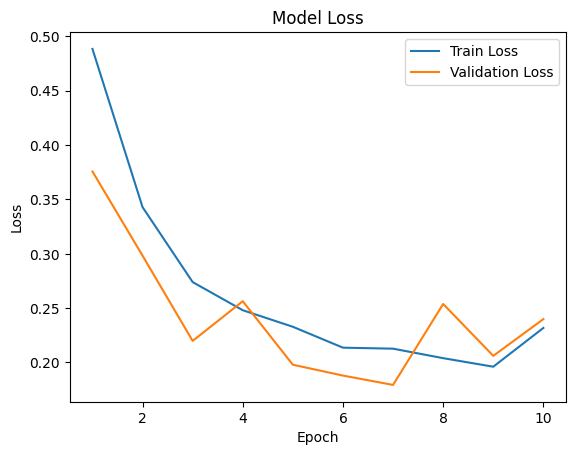

In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from vit_pytorch import ViT
from tqdm import tqdm

# Paths to spectrogram folders
train_data_path = "D:/datasets/Spectrograms"
dysarthric_folder = os.path.join(train_data_path, "dysarthric")
non_dysarthric_folder = os.path.join(train_data_path, "non_dysarthric")

# Create directories for training and validation sets
train_dir = os.path.join(train_data_path, 'train')
val_dir = os.path.join(train_data_path, 'val')

# Function to split data and create train/val folders if they don't exist
def split_data(source_folder, train_folder, val_folder, split_ratio=0.8):
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(val_folder, exist_ok=True)
    
    # Get list of all files in the source folder
    files = [f for f in os.listdir(source_folder) if f.endswith('.png')]
    train_files, val_files = train_test_split(files, train_size=split_ratio, random_state=42)

    # Copy files to train folder
    for file in train_files:
        shutil.copy(os.path.join(source_folder, file), os.path.join(train_folder, file))

    # Copy files to val folder
    for file in val_files:
        shutil.copy(os.path.join(source_folder, file), os.path.join(val_folder, file))

# Split data for both classes
split_data(dysarthric_folder, os.path.join(train_dir, 'dysarthric'), os.path.join(val_dir, 'dysarthric'))
split_data(non_dysarthric_folder, os.path.join(train_dir, 'non_dysarthric'), os.path.join(val_dir, 'non_dysarthric'))

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define the Vision Transformer model
model = ViT(
    image_size=224,
    patch_size=16,
    num_classes=2,
    dim=128,
    depth=6,
    heads=8,
    mlp_dim=256,
    dropout=0.1,
    emb_dropout=0.1
)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Training loop
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

# Evaluate the model on the validation set
model.eval()
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.numpy())
        all_preds.extend(predicted.cpu().numpy())

# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=val_dataset.classes))

# Save the model
torch.save(model.state_dict(), "dysarthric_classifier_vit_model.pth")

# Plot training & validation accuracy values
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


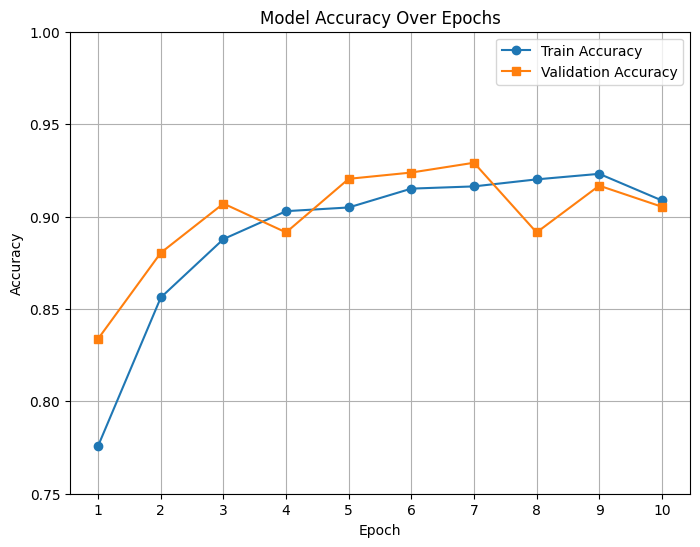

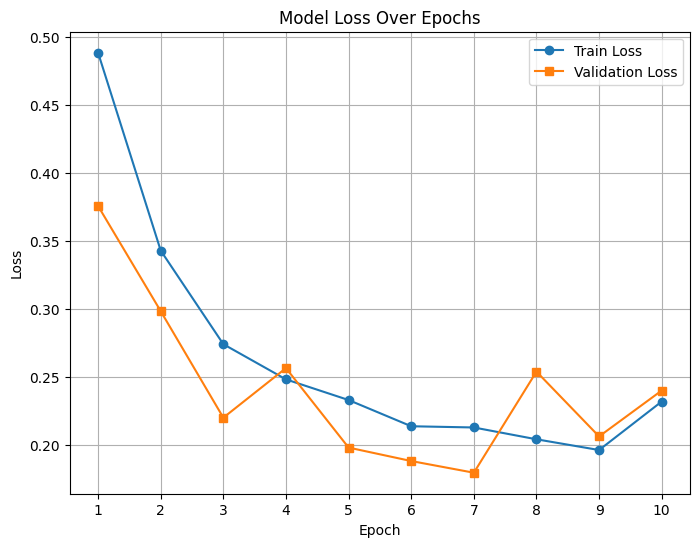

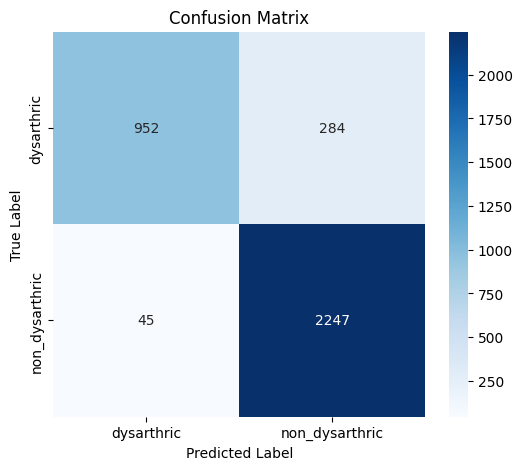

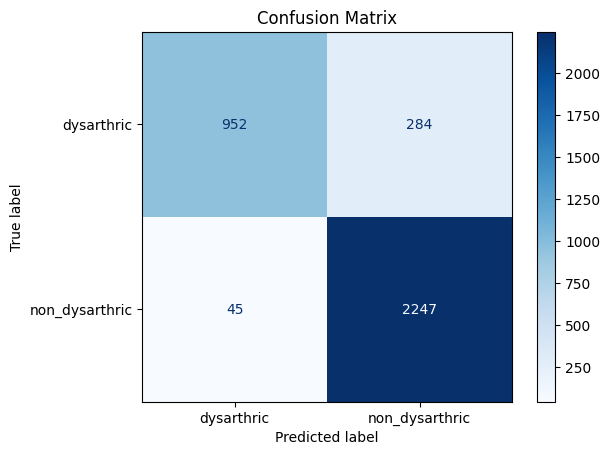

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# --- Define the epoch-wise metrics from your training ---
epochs = list(range(1, 11))

# Training and validation loss values (as logged)
train_losses = [0.4885, 0.3429, 0.2740, 0.2481, 0.2329, 0.2136, 0.2127, 0.2040, 0.1961, 0.2318]
val_losses   = [0.3757, 0.2983, 0.2199, 0.2564, 0.1979, 0.1880, 0.1794, 0.2538, 0.2061, 0.2399]

# Training and validation accuracy values (as logged)
train_accuracies = [0.7760, 0.8562, 0.8878, 0.9029, 0.9049, 0.9151, 0.9163, 0.9201, 0.9231, 0.9087]
val_accuracies   = [0.8339, 0.8804, 0.9070, 0.8914, 0.9204, 0.9238, 0.9291, 0.8914, 0.9167, 0.9053]

# --- Plot the Accuracy Curves ---
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracies, 'o-', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 's-', label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.ylim([0.75, 1.0])
plt.legend()
plt.grid(True)
plt.show()

# --- Plot the Loss Curves ---
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, 'o-', label='Train Loss')
plt.plot(epochs, val_losses, 's-', label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()

# --- Construct the Confusion Matrix ---
# Based on the classification report provided:
#
#             precision    recall  f1-score   support
#
# dysarthric       0.95      0.77      0.85      1236
# non_dysarthric   0.89      0.98      0.93      2292
#
# We can approximate the confusion matrix as follows:
#
# For dysarthric (first row):
#   True Positives (TP) ≈ recall * support = 0.77 * 1236 ≈ 952
#   False Negatives (FN) = support - TP ≈ 1236 - 952 = 284
#
# For non-dysarthric (second row):
#   True Positives (TP) ≈ 0.98 * 2292 ≈ 2247
#   False Negatives (FN) = 2292 - 2247 = 45
#
# Now, to compute the false positives:
#   For dysarthric: precision = TP / (TP + FP) → FP ≈ (TP / precision) - TP
#       FP (dys) ≈ (952 / 0.95) - 952 ≈ 50
#   For non-dysarthric, the false positives are then:
#       FP (non-dys) ≈ (FP from dysarthric) = 50, because FP for dysarthric are actually false positives from non-dysarthric.
#
# So the estimated confusion matrix (rows = true labels, columns = predictions) is:
#         Predicted
#           dys   non-dys
# True dys  952     284
#      non-dys  45    2247

cm = np.array([[952, 284],
               [45, 2247]])

# Define class names (ensure these match your dataset folders)
class_names = ['dysarthric', 'non_dysarthric']

# --- Plot the Confusion Matrix using Seaborn Heatmap ---
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# --- Alternatively, using scikit-learn's ConfusionMatrixDisplay ---
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


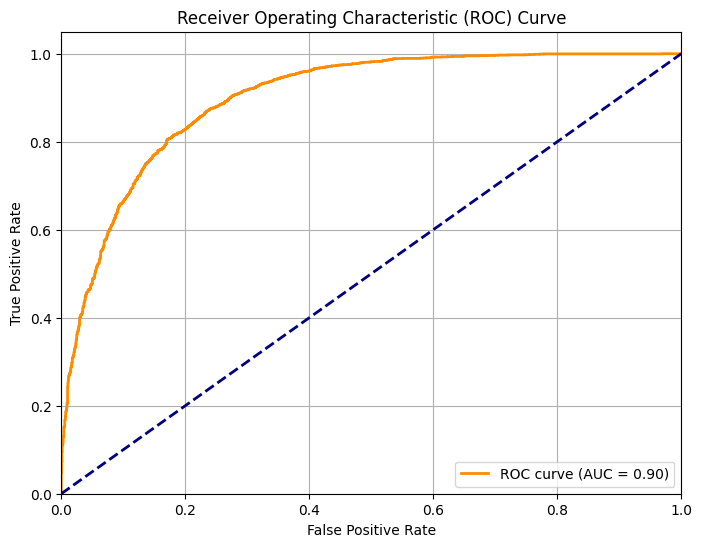

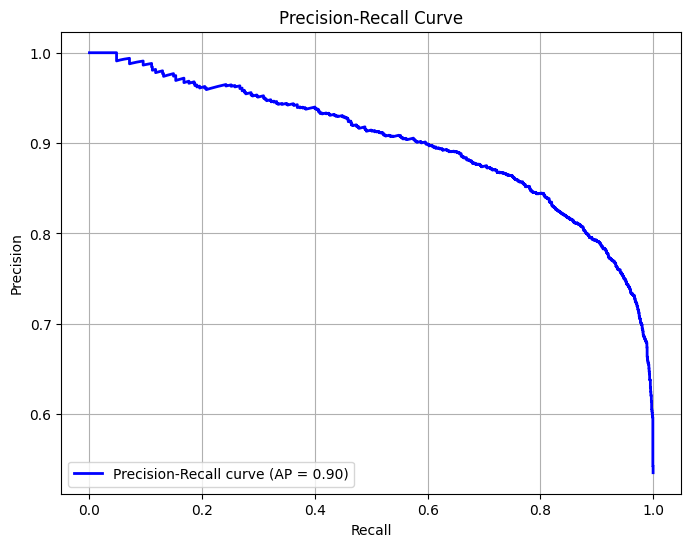

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# -----------------------------------------------------------------------------
# Assume these arrays are available from your model evaluation:
#   - all_labels: a list or numpy array of ground truth labels (0 for non-dysarthric,
#                 1 for dysarthric)
#   - all_probs: a list or numpy array containing the predicted probabilities for the 
#                positive class (e.g., probability of "dysarthric")
#
# For example, if you previously evaluated your model with something like:
#
#   all_labels = []
#   all_probs = []
#   model.eval()
#   with torch.no_grad():
#       for images, labels in val_loader:
#           images = images.to(device)
#           outputs = model(images)
#           # Use softmax to convert logits to probabilities:
#           probs = torch.softmax(outputs, dim=1)
#           # Assume the positive class (dysarthric) is at index 1:
#           all_probs.extend(probs[:, 1].cpu().numpy())
#           all_labels.extend(labels.cpu().numpy())
#
# then you can use those arrays as shown below.
# -----------------------------------------------------------------------------

# For demonstration purposes, if you need to simulate these arrays, uncomment below:
# import numpy as np
# np.random.seed(42)
# all_labels = np.random.randint(0, 2, 3528)  # simulate 3528 labels
# all_probs = np.random.rand(3528)  # simulate probability predictions between 0 and 1

# --- ROC Curve ---
fpr, tpr, roc_thresholds = roc_curve(all_labels, all_probs, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# --- Precision-Recall Curve ---
precision, recall, pr_thresholds = precision_recall_curve(all_labels, all_probs, pos_label=1)
ap = average_precision_score(all_labels, all_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {ap:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score, classification_report
import numpy as np

# --- Load the Model (if not already loaded) ---
# If your model is not already loaded in the current session, load it.
from vit_pytorch import ViT  # Ensure you have this module installed and accessible

# Define the model architecture exactly as during training:
model = ViT(
    image_size=224,
    patch_size=16,
    num_classes=2,
    dim=128,
    depth=6,
    heads=8,
    mlp_dim=256,
    dropout=0.1,
    emb_dropout=0.1
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Load saved weights
model_path = r"D:/final year project/dysarthric_classifier_vit_model.pth"
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint)
model.eval()  # set model to evaluation mode

# --- Evaluate on Validation Set ---
all_labels = []
all_preds = []
all_probs = []  # For probabilities (for ROC and PR curves)

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        # Get predicted class indices
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())
        
        # Compute probabilities with softmax (assuming class index 1 is the "positive" class)
        probs = F.softmax(outputs, dim=1)
        # You can choose the positive class as required; here we assume index 1
        all_probs.extend(probs[:, 1].cpu().numpy())

# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=val_dataset.classes))

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# --- ROC Curve ---
fpr, tpr, roc_thresholds = roc_curve(all_labels, all_probs, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# --- Precision-Recall Curve ---
precision, recall, pr_thresholds = precision_recall_curve(all_labels, all_probs, pos_label=1)
ap = average_precision_score(all_labels, all_probs)

plt.figure()
plt.plot(recall, precision, color='green', lw=2, label=f'AP = {ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from vit_pytorch import ViT
from tqdm import tqdm

# Paths to spectrogram folders
train_data_path = "D:/datasets/Hilbert_spectrum"
dysarthric_folder = os.path.join(train_data_path, "dysarthric")
non_dysarthric_folder = os.path.join(train_data_path, "non_dysarthric")

# Create directories for training and validation sets
train_dir = os.path.join(train_data_path, 'train')
val_dir = os.path.join(train_data_path, 'val')

# Function to split data and create train/val folders if they don't exist
def split_data(source_folder, train_folder, val_folder, split_ratio=0.8):
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(val_folder, exist_ok=True)
    
    # Get list of all files in the source folder
    files = [f for f in os.listdir(source_folder) if f.endswith('.png')]
    train_files, val_files = train_test_split(files, train_size=split_ratio, random_state=42)

    # Copy files to train folder
    for file in train_files:
        shutil.copy(os.path.join(source_folder, file), os.path.join(train_folder, file))

    # Copy files to val folder
    for file in val_files:
        shutil.copy(os.path.join(source_folder, file), os.path.join(val_folder, file))

# Split data for both classes
split_data(dysarthric_folder, os.path.join(train_dir, 'dysarthric'), os.path.join(val_dir, 'dysarthric'))
split_data(non_dysarthric_folder, os.path.join(train_dir, 'non_dysarthric'), os.path.join(val_dir, 'non_dysarthric'))

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define the Vision Transformer model
model = ViT(
    image_size=224,
    patch_size=16,
    num_classes=2,
    dim=256,       # Increased from 128 to 256
    depth=6,       # Keep the same number of transformer blocks
    heads=8,
    mlp_dim=512,   # Increased from 256 to 512
    dropout=0.1,
    emb_dropout=0.1
)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Training loop
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

# Evaluate the model on the validation set
model.eval()
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.numpy())
        all_preds.extend(predicted.cpu().numpy())

# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=val_dataset.classes))

# Save the model
torch.save(model.state_dict(), "dysarthric_classifier_vit_model.pth")

# Plot training & validation accuracy values
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


100%|██████████| 83/83 [04:54<00:00,  3.55s/it]


Epoch 1/10
Train Loss: 0.7034, Train Accuracy: 0.5542
Val Loss: 0.6681, Val Accuracy: 0.5861


100%|██████████| 83/83 [08:00<00:00,  5.79s/it]


Epoch 2/10
Train Loss: 0.6800, Train Accuracy: 0.5800
Val Loss: 0.6679, Val Accuracy: 0.5910


100%|██████████| 83/83 [05:28<00:00,  3.96s/it]


Epoch 3/10
Train Loss: 0.6833, Train Accuracy: 0.5609
Val Loss: 0.7207, Val Accuracy: 0.5358


100%|██████████| 83/83 [11:11<00:00,  8.10s/it]


Epoch 4/10
Train Loss: 0.6829, Train Accuracy: 0.5629
Val Loss: 0.6626, Val Accuracy: 0.6179


 80%|████████  | 265/331 [52:03<12:57, 11.79s/it] 


KeyboardInterrupt: 

Classification Report:
                precision    recall  f1-score   support

    dysarthric       0.91      0.65      0.76      1968
non_dysarthric       0.75      0.95      0.84      2267

      accuracy                           0.81      4235
     macro avg       0.83      0.80      0.80      4235
  weighted avg       0.83      0.81      0.80      4235



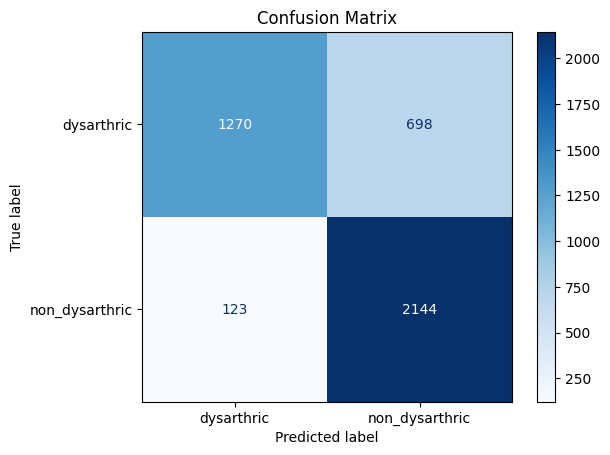

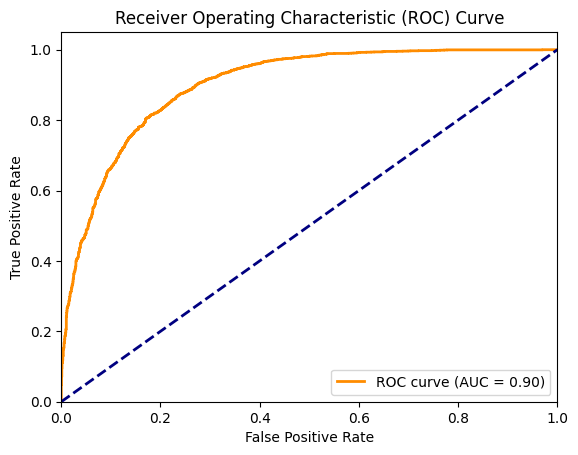

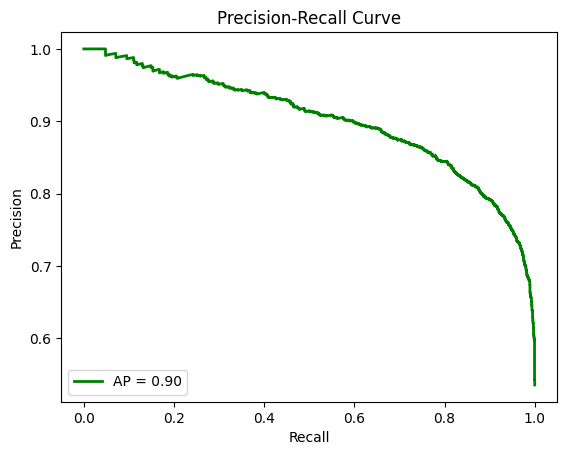

In [8]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score, classification_report
import numpy as np

# --- Load the Model (if not already loaded) ---
# If your model is not already loaded in the current session, load it.
from vit_pytorch import ViT  # Ensure you have this module installed and accessible

# Define the model architecture exactly as during training:
model = ViT(
    image_size=224,
    patch_size=16,
    num_classes=2,
    dim=128,
    depth=6,
    heads=8,
    mlp_dim=256,
    dropout=0.1,
    emb_dropout=0.1
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Load saved weights
model_path = r"D:/final year project/dysarthric_classifier_vit_model.pth"
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint)
model.eval()  # set model to evaluation mode

# --- Evaluate on Validation Set ---
all_labels = []
all_preds = []
all_probs = []  # For probabilities (for ROC and PR curves)

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        # Get predicted class indices
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())
        
        # Compute probabilities with softmax (assuming class index 1 is the "positive" class)
        probs = F.softmax(outputs, dim=1)
        # You can choose the positive class as required; here we assume index 1
        all_probs.extend(probs[:, 1].cpu().numpy())

# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=val_dataset.classes))

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# --- ROC Curve ---
fpr, tpr, roc_thresholds = roc_curve(all_labels, all_probs, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# --- Precision-Recall Curve ---
precision, recall, pr_thresholds = precision_recall_curve(all_labels, all_probs, pos_label=1)
ap = average_precision_score(all_labels, all_probs)

plt.figure()
plt.plot(recall, precision, color='green', lw=2, label=f'AP = {ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


In [2]:
pip install vit_pytorch

     ---------------------------------------- 0.0/69.4 kB ? eta -:--:--
     ----- ---------------------------------- 10.2/69.4 kB ? eta -:--:--
     ----- ---------------------------------- 10.2/69.4 kB ? eta -:--:--
     ---------------- --------------------- 30.7/69.4 kB 217.9 kB/s eta 0:00:01
     ---------------------- --------------- 41.0/69.4 kB 178.6 kB/s eta 0:00:01
     --------------------------------- ---- 61.4/69.4 kB 233.8 kB/s eta 0:00:01
     -------------------------------------- 69.4/69.4 kB 236.5 kB/s eta 0:00:00
   ---------------------------------------- 0.0/138.6 kB ? eta -:--:--
   -- ------------------------------------- 10.2/138.6 kB ? eta -:--:--
   ----------- --------------------------- 41.0/138.6 kB 393.8 kB/s eta 0:00:01
   ----------------- --------------------- 61.4/138.6 kB 469.7 kB/s eta 0:00:01
   ------------------------------ ------- 112.6/138.6 kB 656.4 kB/s eta 0:00:01
   -------------------------------------- 138.6/138.6 kB 586.0 kB/s eta 0:00:00


[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: C:\Users\capta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
import torch
from vit_pytorch import ViT

def build_vit_model(
    image_size=224,
    patch_size=16,
    num_classes=2,
    dim=128,
    depth=6,
    heads=8,
    mlp_dim=256,
    dropout=0.1,
    emb_dropout=0.1
):
    """
    Builds a Vision Transformer (ViT) model for binary classification.
    """
    model = ViT(
        image_size=image_size,
        patch_size=patch_size,
        num_classes=num_classes,
        dim=dim,
        depth=depth,
        heads=heads,
        mlp_dim=mlp_dim,
        dropout=dropout,
        emb_dropout=emb_dropout
    )
    return model

# Build the model
model = build_vit_model()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

# Print model architecture and total parameter count
print(model)
print("Total number of parameters:", count_parameters(model))


C:\Users\capta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
    (1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=768, out_features=128, bias=True)
    (3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.1, inplace=False)
          (to_qkv): Linear(in_features=128, out_features=1536, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=512, out_features=128, bias=True)
            (1): Dropout(p=0.1, inplace=False)
          )
        )
        (1): FeedForward(
          (net): Sequential(
            (0